## 필요한 라이브러리 다운

In [27]:
# 자연어처리에 필요
import nltk
import re
from nltk.tokenize import word_tokenize # 토큰화
from nltk.corpus import stopwords # 불용어제거
from nltk.stem import WordNetLemmatizer # 원형변환

nltk.download('punkt') # 토큰화를 위해 필요한 데이터 다운
nltk.download('stopwords') # 불용어 데이터 다운
nltk.download('wordnet') # WordNetLemmatizer을 사용하기 위한 데이터 다운


import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# 경고메세지 제거
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 데이터 다운로드 
### Dataset Info.

- train.csv [파일]
    - ID : 사건 샘플 ID
    - first_party : 사건의 첫 번째 당사자
    - second_party : 사건의 두 번째 당사자
    - facts : 사건 내용
    - first_party_winner : 첫 번째 당사자의 승소 여부 (0 : 패배, 1 : 승리)

##

- test.csv [파일]
    - ID : 사건 샘플 ID
    - first_party : 사건의 첫 번째 당사자
    - second_party : 사건의 두 번째 당사자
    - facts : 사건 내용

In [28]:
df_train = pd.read_csv('./open/train.csv')
df_test = pd.read_csv('./open/train.csv')

In [3]:
df_train.head()

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [4]:
df_test.head()

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


## EDA

In [5]:
# 결측치 없음
df_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [6]:
# 중복 데이터 확인
df_train['facts'].nunique() # 중복되지 않은 facts 개수 확인 

2478

In [7]:
df_train['facts'].isna().sum() # 결측값 확인 

0

In [8]:
df_train['first_party'].value_counts()

first_party
United States       154
Illinois              9
Maryland              8
Florida               8
New York              7
                   ... 
David Carpenter       1
Larry Gene Heath      1
PGA TOUR, Inc.        1
PPL Montana, LLC      1
Markman               1
Name: count, Length: 2110, dtype: int64

In [9]:
df_train['second_party'].value_counts()

second_party
United States                        240
California                            19
United States of America              15
Illinois                              13
Federal Communications Commission     10
                                    ... 
David Boren, Governor of Oklahoma      1
Federal Bureau of Prisons et al.       1
Town of Harrison                       1
Charles Burr et al.                    1
Westview Instruments, Inc.             1
Name: count, Length: 1974, dtype: int64

In [10]:
df_train['facts']

0       On June 27, 1962, Phil St. Amant, a candidate ...
1       Ramon Nelson was riding his bike when he suffe...
2       An Alabama state court convicted Billy Joe Mag...
3       Victor Linkletter was convicted in state court...
4       On April 24, 1953 in Selma, Alabama, an intrud...
                              ...                        
2473    Congress amended the Clean Air Act through the...
2474    Alliance Bond Fund, Inc., an investment fund, ...
2475    In 1992, the District Court sentenced Manuel D...
2476    On March 8, 1996, Enrico St. Cyr, a lawful per...
2477    Herbert Markman owns the patent to a system th...
Name: facts, Length: 2478, dtype: object

In [11]:
df_train['first_party_winner'].value_counts()

first_party_winner
1    1649
0     829
Name: count, dtype: int64

<Axes: xlabel='first_party_winner', ylabel='count'>

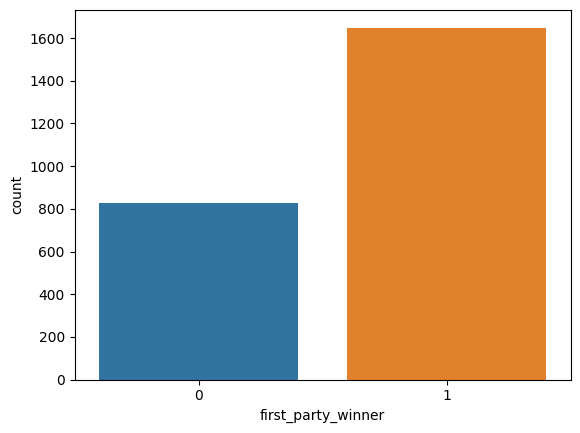

In [13]:
# 데이터 분할시 라벨의 분포 고려
sns.countplot(x = 'first_party_winner', data=df_train)

In [14]:
facts_len = df_train['facts'].apply(len) # 길이
facts_len.head()

0    1092
1    1180
2    1112
3     356
4    1067
Name: facts, dtype: int64

(array([ 62., 299., 488., 669., 443., 253., 130.,  76.,  34.,  11.,   9.,
          2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  15.,  304.,  593.,  882., 1171., 1460., 1749., 2038., 2327.,
        2616., 2905., 3194., 3483., 3772., 4061., 4350., 4639., 4928.,
        5217., 5506., 5795.]),
 <BarContainer object of 20 artists>)

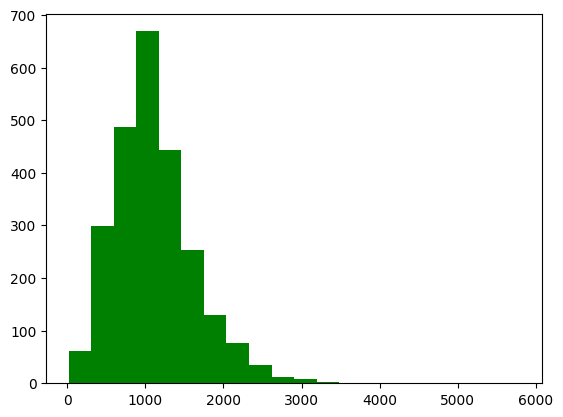

In [15]:
plt.hist(facts_len, bins=20, color='green')

(-0.5, 799.5, 599.5, -0.5)

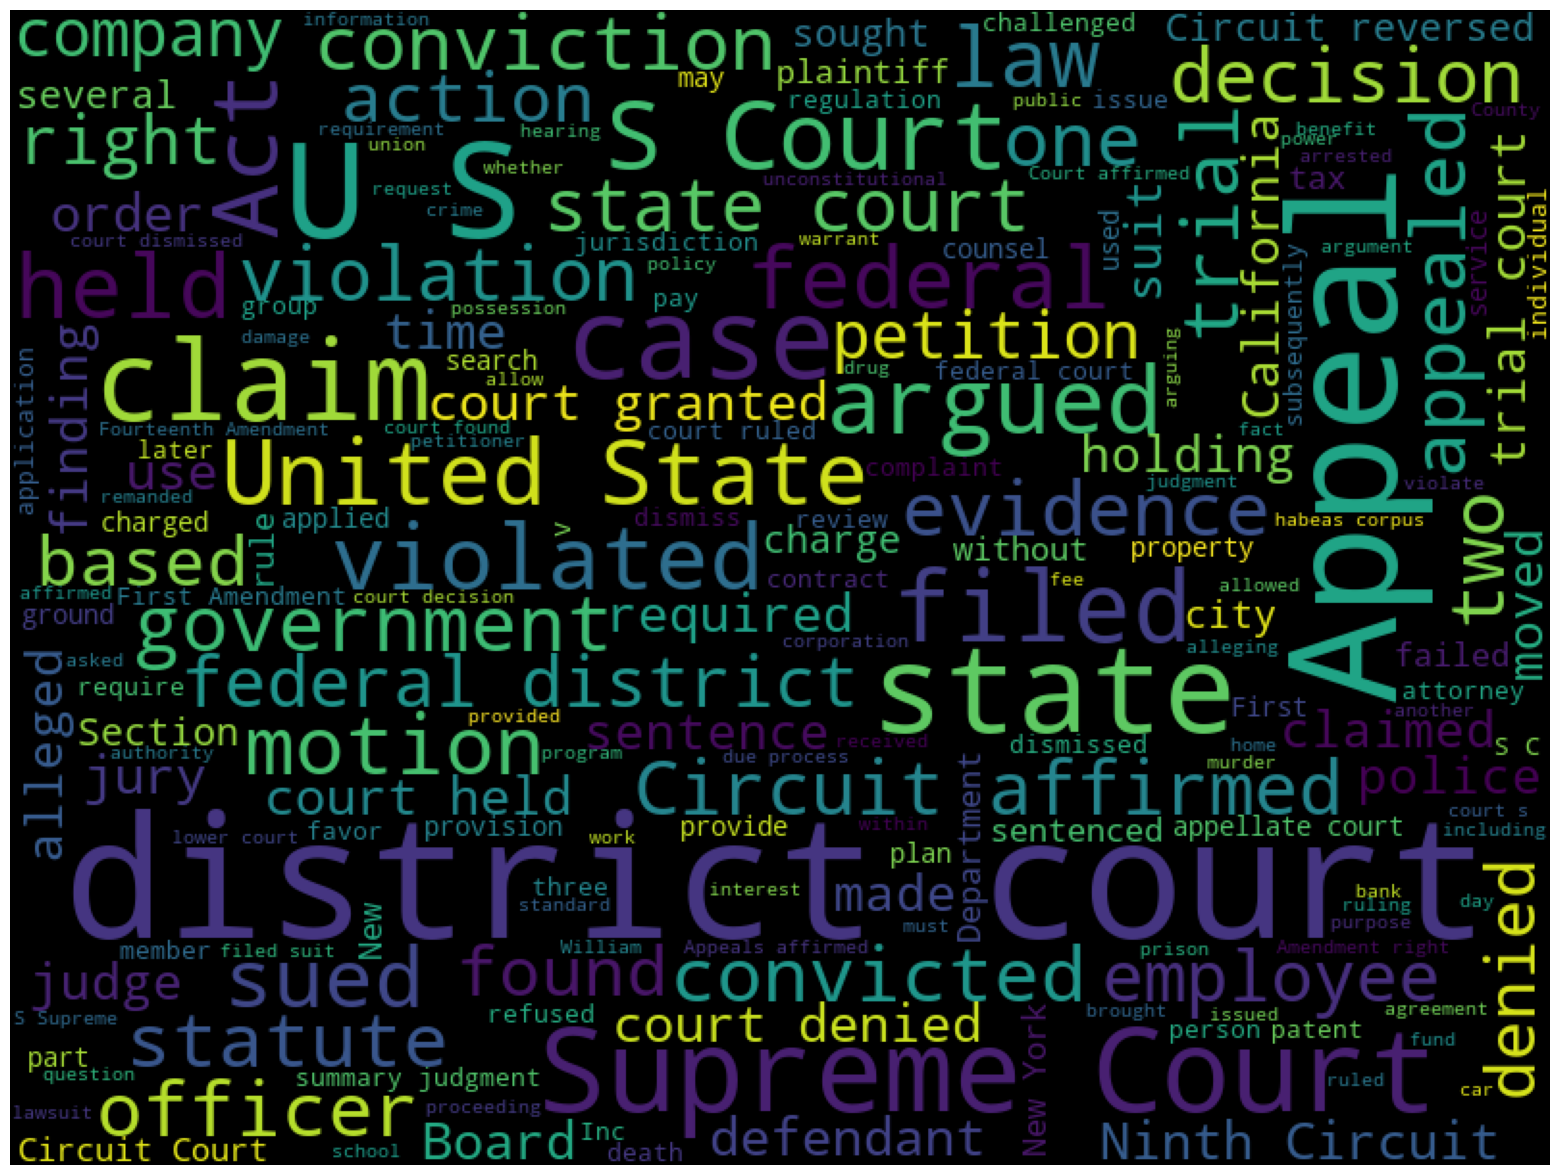

In [16]:
from wordcloud import WordCloud
cloud=WordCloud(width=800, height=600).generate(" ".join(df_train['facts']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

## 전처리

In [17]:
stop_words = set(stopwords.words('english')) # 불용어 리스트 가져오기
# stop_words

하나하나 전처리 진행이 힘들어! >  함수로 만들어서 처리함

In [18]:
# # 전처리 함수 정의(리스트 형식)
# def processing_text(text):
#     lemmatizer = WordNetLemmatizer()
#     tokens = word_tokenize(text) # 토큰화 
#     clean_words = [word for word in tokens if word.isalnum()] # 구두점 제거
#     filtered_words = [word for word in clean_words if word.lower() not in stop_words] # 불용어 제거
#     lemmatized_words = [ lemmatizer.lemmatize(word) for word in filtered_words] # 원형
#     return lemmatized_words
#     # lemmatized_text = ' '.join(lemmatized_words)
#     # return  lemmatized_text

In [19]:
# # 전처리 함수 정의(한문장으로 연결) > 숫자 남김
# def processing_text(text):
#     lemmatizer = WordNetLemmatizer()
#     tokens = word_tokenize(text) # 토큰화 
#     clean_words = [word for word in tokens if word.isalnum()] # 구두점 제거
#     filtered_words = [word for word in clean_words if word.lower() not in stop_words] # 불용어 제거
#     lemmatized_words = [ lemmatizer.lemmatize(word) for word in filtered_words] # 원형
#     lemmatized_text = ' '.join(lemmatized_words) # 단어리스트를 하나의 글로 합치기
#     return  lemmatized_text

In [29]:
# 전처리 함수 정의(한문장으로 연결) - 영어제외하고 모두 제거
def processing_text(text):
    lemmatizer = WordNetLemmatizer()
    text = re.sub("[^a-zA-Z]", " ", text) # 영어가 아닌 특수문자를 공백으로
    tokens = word_tokenize(text) # 토큰화 
    filtered_words = [word for word in tokens if word.lower() not in stop_words] # 불용어 제거
    lemmatized_words = [ lemmatizer.lemmatize(word) for word in filtered_words] # 원형
    lemmatized_text = ' '.join(lemmatized_words) # 단어리스트를 하나의 글로 합치기
    return  lemmatized_text

In [30]:
# 전처리함수 적용하고 소문자로 변경 
df_train['filter_text'] = df_train['facts'].apply(processing_text).str.lower()
df_test['filter_text'] = df_test['facts'].apply(processing_text).str.lower()

In [31]:
df_train.head()

,ID,first_party,second_party,facts,first_party_winner,filter_text
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1,june phil st amant candidate public office mad...
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0,ramon nelson riding bike suffered lethal blow ...
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1,alabama state court convicted billy joe magwoo...
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0,victor linkletter convicted state court eviden...
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1,april selma alabama intruder broke apartment d...


## 데이터 변환

### TfidfVectorizer
- 단어의 횟수와 중요도를 고려하여 벡터화?

In [32]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['filter_text'])
    else:
        X_facts = vectorizer.transform(df["filter_text"])
    X_party1 = vectorizer.transform(df["first_party"])
    X_party2 = vectorizer.transform(df["second_party"])

    X = np.concatenate([X_party1.toarray(), X_party2.toarray(), X_facts.toarray()], axis=1)
    return X

In [33]:
# 데이터 벡터화 함수 적용 및 분할 
X = get_vector(vectorizer, df_train, True)
y = df_train["first_party_winner"]

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## 모델링

### 1. MLP

In [25]:
# 모델생성
model = MLPRegressor()
# 모델학습 
model.fit(X_train,y_train)

MLPRegressor()

In [26]:
from sklearn.metrics import accuracy_score

# 모델검증 
y_val_predict = model.predict(X_val)
y_val_predict = pd.DataFrame(y_val_predict)[0].apply(lambda x: 1 if x >= 0.5 else 0) # 데이터 프레임 화 해야함 더 이쁜 코드 없을까나 ㅎㅋㅎㅋㅎ

print(accuracy_score(y_val_predict, y_val))

0.5705645161290323


In [39]:
# 모델예측 
X_test = get_vector(vectorizer, df_test, True) 
y_test = df_test["first_party_winner"]
y_test_predict = model.predict(X_test)
y_test_predict =  pd.DataFrame(y_test_predict)[0].apply(lambda x: 1 if x >= 0.5 else 0) # 데이터 프레임 화 해야함 더 이쁜 코드 없을까나 ㅎㅋㅎㅋㅎ

print(accuracy_score(y_test, y_test_predict))

0.914043583535109


### 2. 로지스틱 회귀분석

In [40]:
from sklearn.linear_model import LogisticRegression

lgs = LogisticRegression()

lgs.fit(X_train, y_train)

LogisticRegression()

In [41]:
from sklearn.metrics import accuracy_score

# 모델검증 
y_val_predict = lgs.predict(X_val)

print(accuracy_score(y_val_predict, y_val)) 

0.6391129032258065


In [43]:
# 모델예측 
X_test = get_vector(vectorizer, df_test, True) 
y_test = df_test["first_party_winner"]
y_test_predict = lgs.predict(X_test)
# y_test_predict
print(accuracy_score(y_test, y_test_predict))

0.8825665859564165


###  3. 랜덤 포레스트 모델

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
# 모델검증 
y_val_predict = forest.predict(X_val)

print(accuracy_score(y_val_predict, y_val)) 

0.6532258064516129


In [47]:
# 모델예측 
X_test = get_vector(vectorizer, df_test, True) 
y_test = df_test["first_party_winner"]
y_test_predict = forest.predict(X_test)
# y_test_predict
print(accuracy_score(y_test, y_test_predict))

0.930589184826473


## 시도하려하였으나 실패한 모델

### word2vec 모델
- 너무 복잡해보임 ㅠㅡㅠ


### LSTM(Long Short-Term Memory)
- 순환 신경망(RNN) 기법 중 하나  > 재귀신경망을 많이 씀 !! 


### CNN(합성곱신경망)